# Primary Model Pipeline

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import signal
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [ ]:
df.head()

In [ ]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [ ]:
df.describe()

### FFT
**Transforming to spectrograms**

In [ ]:
# y axis corresponds to frequencies (units are hz?)
# x axis corresponds to times (units are samples?)
# Each square corresponds to the magnitude (the absolute value the wave differs from 0)
shape = (6, 21, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 10
noverlap = 8
reshape = (-1, shape[0], shape[1], shape[2])
j = 0
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

In [ ]:
#Spectrogram hyperparameters
nperseg=40 #increasing nperseg increases frequency resolution and decreases time res
noverlap=11 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

#Spectrogram
frequencies, times, spec = signal.spectrogram(x=df['ch1'][24:48],
                                              fs=50, nperseg=nperseg,
                                              noverlap=noverlap, window=window)
print('frequencies', frequencies.shape)
print('times', times.shape)
#print(spec)
#Subplot 1
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 2
frequencies, times, spec = signal.spectrogram(x=df['ch2'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 3
frequencies, times, spec = signal.spectrogram(x=df['ch3'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 4
frequencies, times, spec = signal.spectrogram(x=df['ch4'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show


#Subplot 5
frequencies, times, spec = signal.spectrogram(x=df['ch5'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 6
frequencies, times, spec = signal.spectrogram(x=df['ch6'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 7
frequencies, times, spec = signal.spectrogram(x=df['ch7'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Subplot 8
frequencies, times, spec = signal.spectrogram(x=df['ch8'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.show

#Specs and Shapes
#print('label:', label_dir)
#print('file:', file)
print('spec_shape:', spec.shape)
print('frequencies_shape:', frequencies.shape)
print('times_shape:', times.shape)

In [ ]:
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']
shape = (7, 13, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 12
noverlap = 11
reshape = (-1, shape[0], shape[1], shape[2])
j = 1
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

img = np.zeros(shape)
k = 0
num_samples = len(df)
x_shape = (num_samples, 7, 13, 8)
x1_train = np.zeros(x_shape)

for i in range(len(df) - 24):
    for j in range(8):
        frequencies, times, spec = signal.spectrogram(x=df[channels[j]][k:k+24], fs=50,
                                                  nperseg=nperseg, noverlap=noverlap,
                                                  window='hann')
        log_spec = np.log(spec)
        img[:,:,j] = spec
        j = j + 1
    x1_train[i,:,:,:] = img
    i = i + 1
    k = k + 1
    if i == 4457:
        print(df.iloc[i,:])
    print(i)
print(x1_train.shape)
flat = np.reshape(x1_train, (num_samples, flat_dim))
df_train1 = pd.DataFrame(data=flat)
df_train_g = df_train_g.append(df_train1, ignore_index=True)

In [ ]:
df_train_g.head()

In [ ]:
def preprocess_features(x_train):
    shape = (7, 13, 8)
    reshape = (-1, shape[0], shape[1], shape[2])
    x_train = x_train.replace(-np.inf, 0)
    x_train = x_train.replace(np.inf, 0)
    #x_train = np.log(x_train.values)
    x_train = x_train.values
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

features = preprocess_features(df_train_g)

In [3]:
features.shape

NameError: name 'features' is not defined

In [18]:
labels = df.loc[:, 'Wrist x':].values

## Conv_LSTM

In [ ]:
seq_length = 24

def reshape_overlap_samples(seq_length, feats, labels):
    samples = feats.shape[0] - (seq_length - 1)    # all samples except the last sequence
    shape = (24, 7, 13, 8)
    new_f = np.zeros(shape=(samples, 24, 7, 13, 8))
    print(new_f.shape)
    new_l = labels[seq_length - 1:]
    queue = collections.deque(feats[:seq_length])
    new_f[0] = np.array(queue)
    j = 1
    for i in range(seq_length, feats.shape[0]):
        queue.popleft()
        queue.append(feats[i])
        new_f[j] = np.array(queue)
        j += 1
    return (new_f, new_l)

features_ol, labels_ol = reshape_overlap_samples(seq_length, features, labels)
print(features_ol.shape)
print(labels_ol.shape)

(106956, 24, 7, 13, 8)


In [68]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    
    norm_input = BatchNormalization()(inputlayer)
    model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(norm_input)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    #model = Dropout(rate=0.5)(model)
    model = Flatten()(model)
    #mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    model = Dense(63, activation='None')(model)
    #dense_5 = Dense(63, activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(model)
    #model = Dropout(rate=0.2)(model)
    #model = ConvLSTM2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = ConvLSTM2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(model)
    #model = Dropout(rate=0.2)(model)
    #model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = TimeDistributed(MaxPooling2D(pool_size=(1, 1)))(model)
    #model = Flatten()(model) 

    #dense_1 = BatchNormalization()(Dense(128, activation='relu')(model))
    #dense_2 = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    #dense_1 = Dense(nclass, activation='softmax')(dense_1)

    #lstm layers
    #inputs = Input(shape=(None, 128), name="inputs")(dense_2)
    #lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(dense_2)
    #do = Dropout(0.4)(lstm_0)
    #lstm_1 = LSTM(100, return_sequences=True, name="lstm_1")(do)
    #do_2 = Dropout(0.4)(lstm_1)
    #lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
    
    #dense_3 = Dense(128, activation='relu', name="dense_3")(lstm_1)
    #dense_4 = BatchNormalization()(Dense(128, activation='relu')(dense_3))
    #dense_5 = Dense(128, activation='relu')(dense_4)
    #dense_6 = BatchNormalization()(Dense(128, activation='relu')(dense_5))
    #dense_5 = Dense(64, activation='relu')(dense_4)
    
    #model_fc.add(Dense(100, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(BatchNormalization())
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(64, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(63, input_dim=64))
    
    #decoder layers
    #decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
    #decoder_0.trainable = False
    #decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
    #decoder_1.trainable = False
    #decoder_output = decoder.get_layer("decoder_output")(decoder_1)
    #decoder_output.trainable = False
    
    model = Model(inputs=inputlayer, outputs=model)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

shape = (24, 7, 13, 8)
model = create_model(shape)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 24, 7, 13, 8)      0         
_________________________________________________________________
batch_normalization_v1_28 (B (None, 24, 7, 13, 8)      32        
_________________________________________________________________
conv_lst_m2d_24 (ConvLSTM2D) (None, 24, 7, 13, 16)     6208      
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 7, 13, 16)     0         
_________________________________________________________________
conv_lst_m2d_25 (ConvLSTM2D) (None, 7, 13, 32)         24704     
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 13, 32)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2912)              0         
__________

In [69]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [70]:
model.evaluate(features_ol, labels_ol, verbose=1)

  928/19977 [>.............................] - ETA: 2:36 - loss: 5118735.4261

KeyboardInterrupt: 

In [71]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=2
                    , verbose=1, validation_split=0.2, shuffle=False)

Train on 15981 samples, validate on 3996 samples
Epoch 1/2
  408/15981 [..............................] - ETA: 7:39 - loss: 1657.2771

KeyboardInterrupt: 

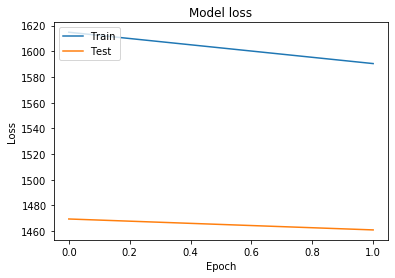

In [52]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN + LSTM

In [71]:
def create_model(input_shape):

    inputlayer = Input(shape=input_shape)
    norm_input = BatchNormalization()(inputlayer)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(norm_input)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(model)
    model = BatchNormalization()(model)
    #model = BatchNormalization()(TimeDistributed(Dense(128, activation='relu')(model)))
    model = TimeDistributed(Flatten())(model)
    model = LSTM(64, activation='relu', return_sequences=True)(model)
    model = LSTM(64, activation='relu', return_sequences=False)(model)
    model = BatchNormalization()(Dense(63, activation='relu')(model))
    dense = Dense(63, activation='relu')(model)
    
    #norm_input = BatchNormalization()(inputlayer)
    #model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(norm_input)
    #model = Conv2D(32, kernel_size=2, padding='same', activation='relu')(model)
    #model = MaxPooling2D(pool_size=(2, 2))(model)
    #model = Dropout(rate=0.2)(model)
    #model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model)
    #model = MaxPooling2D(pool_size=(2, 2))(model)
    #model = Dropout(rate=0.2)(model)
    #vmodel = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Conv2D(128, kernel_size=3, padding='same', activation='relu')(model)
    #model = MaxPooling2D(pool_size=(1, 1))(model)
    #model = Flatten()(model) 

    #dense_1 = BatchNormalization()(Dense(128, activation='relu')(model))
    #dense_2 = BatchNormalization()(Dense(128, activation='relu')(dense_1))
    #dense_1 = Dense(nclass, activation='softmax')(dense_1)
    
    #lstm layers
    #inputs = Input(shape=(None, 128))(dense_2)
    #dense_3 = Dense(128, activation='relu', name="dense_3")(dense_2)
    #lstm_0 = LSTM(100, input_shape=(128,), return_sequences=True, name="lstm_0")(dense_3)
    #do = Dropout(0.4)(lstm_0)
    #stm_1 = LSTM(100, return_sequences=True, name="lstm_1")(do)
    #do_2 = Dropout(0.4)(lstm_0)
    #lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
    
    #dense_3 = Dense(128, activation='relu', name="dense_3")(lstm_1)
    #dense_4 = BatchNormalization()(Dense(128, activation='relu')(dense_3))
    #dense_5 = Dense(128, activation='relu')(dense_4)
    #dense_6 = BatchNormalization()(Dense(128, activation='relu')(dense_5))
    #dense_5 = Dense(64, activation='relu')(dense_4)
    
    #model_fc.add(Dense(100, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(BatchNormalization())
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(64, input_dim=64))
    #model_fc.add(Activation('relu'))
    #model_fc.add(Dropout(0.2))
    #model_fc.add(Dense(63, input_dim=64))
    
    #decoder layers
    #decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
    #decoder_0.trainable = False
    #decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
    #decoder_1.trainable = False
    #decoder_output = decoder.get_layer("decoder_output")(decoder_1)
    #decoder_output.trainable = False
    
    model = Model(inputs=inputlayer, outputs=dense)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model


print(shape)
model = create_model((24, 7, 13, 8))

model.summary()

(7, 13, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 24, 7, 13, 8)      0         
_________________________________________________________________
batch_normalization_v1_71 (B (None, 24, 7, 13, 8)      32        
_________________________________________________________________
time_distributed_53 (TimeDis (None, 24, 7, 13, 32)     1056      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 24, 7, 13, 32)     4128      
_________________________________________________________________
batch_normalization_v1_72 (B (None, 24, 7, 13, 32)     128       
_________________________________________________________________
time_distributed_55 (TimeDis (None, 24, 2912)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 24, 64)            762112    

In [72]:
model.compile(optimizer='Adam', loss='mse')

In [ ]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

## conv_lstm_2d

In [ ]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = ConvLSTM2D(100, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.4)(lstm_0)
lstm_1 = ConvLSTM2D(100, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.4)(lstm_0)
lstm_1 = ConvLSTM2D(100, return_sequences=False, name="lstm_1")(do_2)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [16]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [17]:
feature_ar.shape

(106979, 8)

In [18]:
label_ar.shape

(106979, 63)

Build the autoencoder structure:

In [19]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
______________________

In [20]:
autoencoder.evaluate(label_ar, label_ar)

106979/106979 [==============================] - 2s 22us/sample - loss: 2075.7868


2075.7868355574788

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [23]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=312, epochs=3, verbose=1, validation_split=0.2)

Train on 85583 samples, validate on 21396 samples
Epoch 1/3
85583/85583 [==============================] - 1s 10us/sample - loss: 27.4648 - val_loss: 30.2431
Epoch 2/3
85583/85583 [==============================] - 1s 10us/sample - loss: 25.0079 - val_loss: 27.6195
Epoch 3/3
85583/85583 [==============================] - 1s 10us/sample - loss: 23.3839 - val_loss: 26.2109


Now the encoder - decoder pair will be tested seperately for loss:

In [24]:
encoded_vec = encoder.predict(label_ar)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_ar)

106979/106979 [==============================] - 2s 17us/sample - loss: 23.4510


23.450966647503495

In [25]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(106979, 9)
(106979, 63)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [10]:
seq_length = 24

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

NameError: name 'feature_ar' is not defined

### Attention
**This model will incorporate a component of attention**


### Model from phillip peremy
https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py
Attention vector

Also, sometimes the time series can be N-dimensional. It could be interesting to have one atention vector per dimension. Let's

Attention can just then be a softmax applied to an output of something?

The permute function switches the positions of the axis and the dims argument tells how you want the final positions to be.

For example, if x is 4-dimensional and of the shape (None, 2, 4, 5, 8) - (None is the batch size here) and if you specify dims = (3, 2, 1, 4), then the following four steps will take place:

1. Third dimension will move to first
2. Second dimension will move to second
3. First dimension will move to third
4. Fourth dimension will move to fourth

Remember, the indexing starts at 1 and not 0. The dimension zero is the batch size. So finally the output

**RepeatVector**
Repeats the input vector n times



In [19]:
INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Add()([inputs, a_probs])
    return output_attention_mul

def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs, output)
    return model

model = model_attention_applied_after_lstm()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 32)       4480        input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 32, 20)       0           lstm[0][0]                       
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32, 20)       0           permute[0][0]                    
_____________________________________

In [35]:
#from keras.layers.core import*
#from keras.models import Sequential

input_dim = 32
hidden = 32

#The LSTM  model -  output_shape = (batch, step, hidden)
model1 = Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model1.add(LSTM(input_dim=input_dim, output_dim=hidden, input_length=step, return_sequences=True))

#The weight model  - actual output shape  = (batch, step)
# after reshape : output_shape = (batch, step,  hidden)
model2 = Sequential()
model2.add(Dense(input_dim=input_dim, output_dim=step))
model2.add(Activation('softmax')) # Learn a probability distribution over each  step.
#Reshape to match LSTM's output shape, so that we can do element-wise multiplication.
model2.add(RepeatVector(hidden))
model2.add(Permute(2, 1))

#The final model which gives the weighted sum:
model = Sequential()
model.add(Merge([model1, model2], 'mul'))  # Multiply each element with corresponding weight a[i][j][k] * b[i][j]
model.add(TimeDistributedMerge('sum')) # Sum the weighted elements.

model.compile(loss='mse', optimizer='sgd')

NameError: name 'model_fc' is not defined

In [27]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")

lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)

attention = Dense(1, activation='tanh')(lstm_1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(100)(attention)
attention = Permute([2, 1])(attention)
sent_representation = merge([lstm_1, attention])
attention = Activation('softmax')(attention)
lstm_out = Dense(9, activation=None, name="lstm_out")(sent_representation)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: name 'merge' is not defined

### LSTM model

In [31]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(100, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.4)(lstm_0)
lstm_1 = LSTM(100, return_sequences=False, name="lstm_1")(do_2)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, 8)           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 100)         43600     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 909       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
__________

In [32]:
model.evaluate(features, labels, verbose=1)

388658/388658 [==============================] - 164s 422us/sample - loss: 731.0006


731.000609906823

In [33]:
history = model.fit(features, labels, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 310926 samples, validate on 77732 samples
Epoch 1/4
310926/310926 [==============================] - 588s 2ms/sample - loss: 203.7043 - val_loss: 598.5922
Epoch 2/4
310926/310926 [==============================] - 582s 2ms/sample - loss: 154.3962 - val_loss: 596.6076
Epoch 3/4
140448/310926 [============>.................] - ETA: 5:01 - loss: 140.8171

KeyboardInterrupt: 

In [23]:
model.save('AE_jose_mega_val_loss_600_model.h5')

### Visualize Model Error

Plot the validation loss over the training epochs:

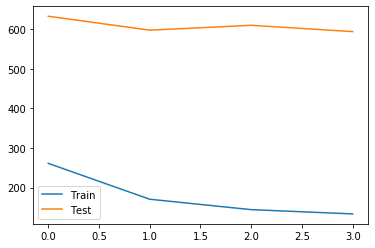

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [35]:
preds = model.predict(features)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

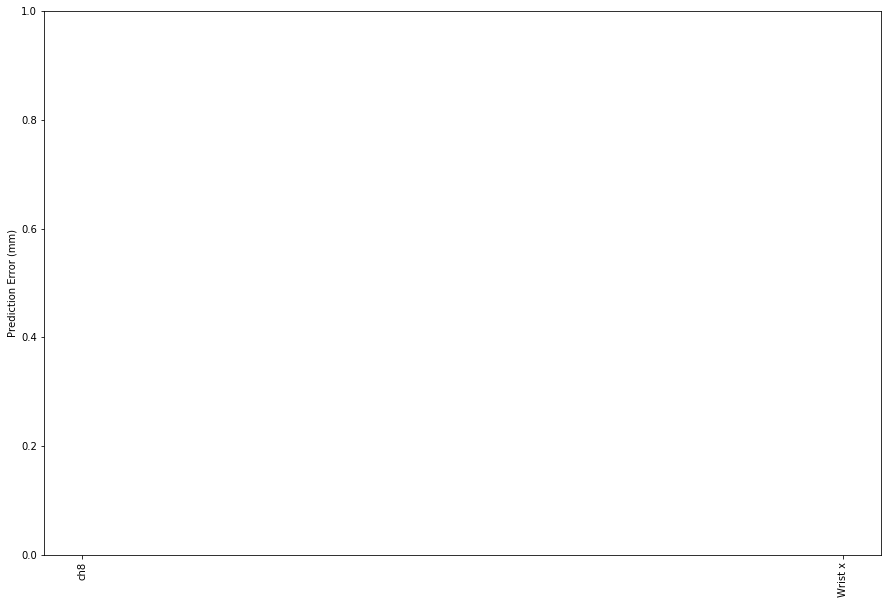

In [36]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [27]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 13160 samples, validate on 3290 samples
Epoch 1/5
13160/13160 [==============================] - 25s 2ms/sample - loss: 446.7564 - val_loss: 101.6531
Epoch 2/5
 6592/13160 [==============>...............] - ETA: 10s - loss: 118.3758

KeyboardInterrupt: 

In [28]:
model_fc.save('FC_model_jose_finger_4.h5')

### Visual Model Error

In [26]:
preds = model_fc.predict(features)

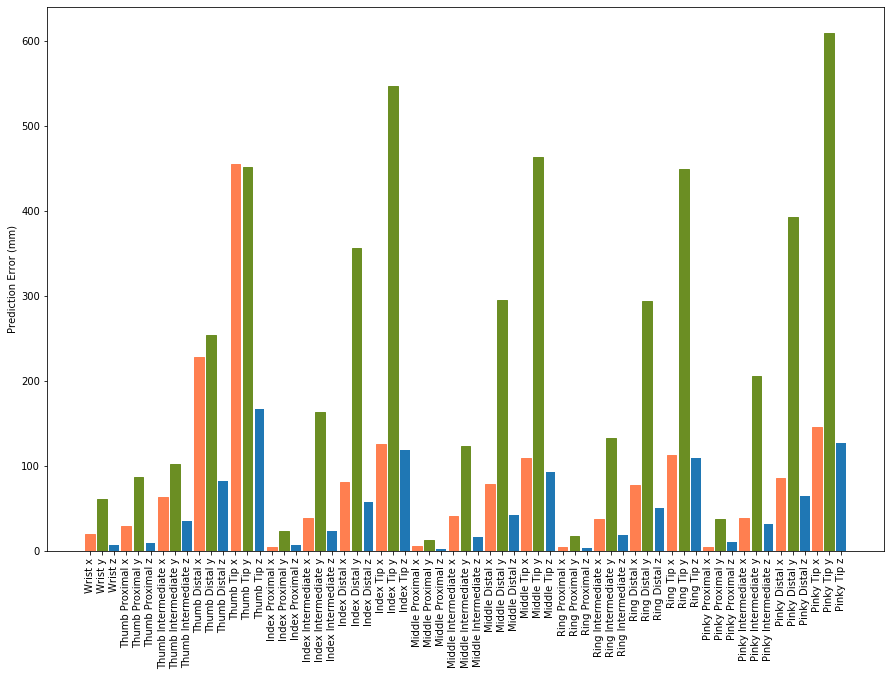

In [27]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

### Autoencoder Architecture

In [29]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [30]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

(16481, 18)

In [31]:
ret = autoencoder.fit(label_ar_t, label_ar_t, batch_size=512, epochs=30, verbose=1, validation_split=0.2)

Train on 13184 samples, validate on 3297 samples
Epoch 1/30
13184/13184 [==============================] - 2s 125us/sample - loss: 1804.8644 - val_loss: 844.6304
Epoch 2/30
13184/13184 [==============================] - 0s 6us/sample - loss: 363.1596 - val_loss: 143.7439
Epoch 3/30
13184/13184 [==============================] - 0s 6us/sample - loss: 108.8713 - val_loss: 135.5584
Epoch 4/30
13184/13184 [==============================] - 0s 6us/sample - loss: 84.1743 - val_loss: 121.3580
Epoch 5/30
13184/13184 [==============================] - 0s 6us/sample - loss: 70.7524 - val_loss: 107.9477
Epoch 6/30
13184/13184 [==============================] - 0s 7us/sample - loss: 59.9721 - val_loss: 100.2388
Epoch 7/30
13184/13184 [==============================] - 0s 6us/sample - loss: 51.1394 - val_loss: 91.6366
Epoch 8/30
13184/13184 [==============================] - 0s 6us/sample - loss: 44.0869 - val_loss: 85.8753
Epoch 9/30
13184/13184 [==============================] - 0s 6us/sample - l

Create a smaller labels vector with only the tip and wrist x,y,z:

In [31]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(89004, 18)

In [32]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 8)]         0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528

In [33]:
history = model.fit(features, labels_tip, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 71203 samples, validate on 17801 samples
Epoch 1/4
71203/71203 [==============================] - 88s 1ms/sample - loss: 371.7387 - val_loss: 296.5638
Epoch 2/4
71203/71203 [==============================] - 81s 1ms/sample - loss: 258.2415 - val_loss: 275.9274
Epoch 3/4
71203/71203 [==============================] - 77s 1ms/sample - loss: 218.4306 - val_loss: 257.8691
Epoch 4/4
71203/71203 [==============================] - 82s 1ms/sample - loss: 194.0974 - val_loss: 247.3258


### Visual Model Error
Model error for the reduced Autoencoder architecture:

In [34]:
preds = model.predict(features)

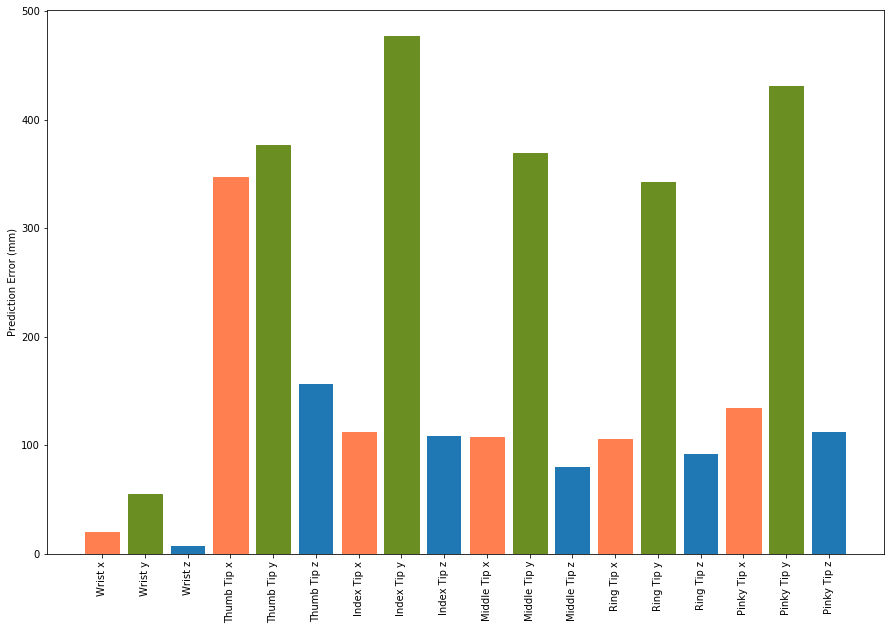

In [35]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Tips only with FC Architecture

In [68]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.summary()
model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=9, verbose=1, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            18688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 100)               400       
__________

NameError: name 'labels_tip' is not defined

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

In [37]:
preds = model_fc.predict(features)

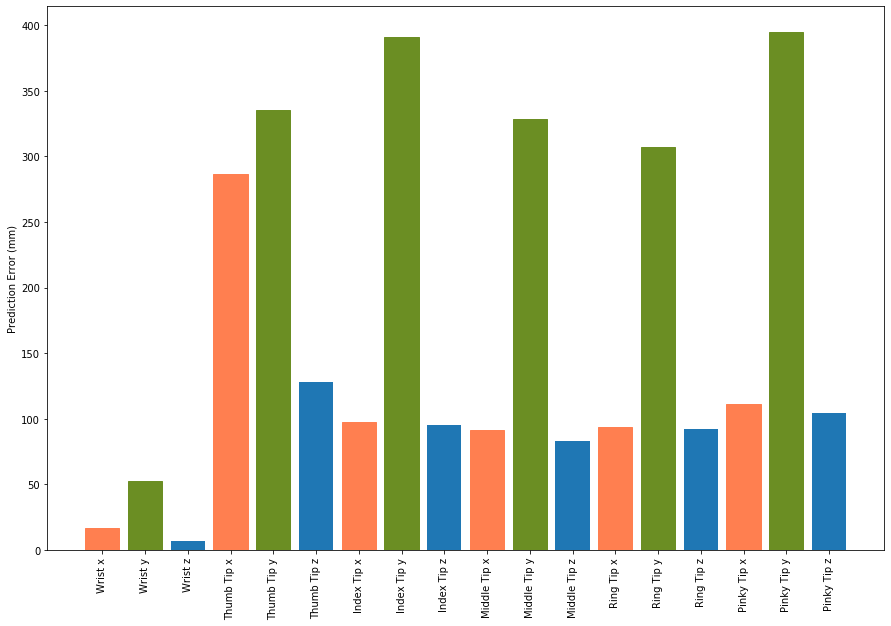

In [38]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()